# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

Inital State: An empty board <br>
Actions: Open columns, bottom of columns where an opponents piece has been placed.<br>
Transition Model: Place a friendly piece at the top of an open column, or remove an opponents piece from the bottom of a column, which shifts the rest of the column down, and place their piece in an open column. <br>
Test for Terminal State: Did a player place at least 4 pieces in a row (vertically, horizonally, or diagonally)? <br>
Utility for Terminal State: ?????????<br>

How big is the state space? Give an estimate and explain it.

Since there are 42 possible positions on a 7x6 board, and each position can be in 1 of 3 states (friend piece, enemy piece, no piece), the state space size would be slightly less than $3^{42} ≈ 1.094*10^{20}$ .<br><br>

The state space is less because there are rule constraints that prevent certain configurations from occuring; the game ends when at least one player has at least 4 consecutive pieces on the board. Therefore there can be a board with multiple sets of at least 4 consecutive, same-color pieces, if and only if there exists a common column where every set has at least 1 piece.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [3]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [4]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0).tolist()

print(empty_board())

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

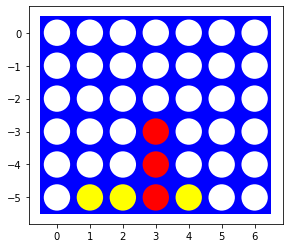

In [5]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

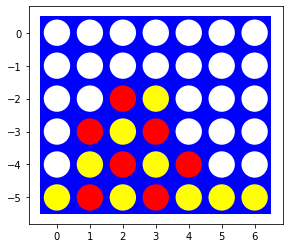

-1


In [246]:
import copy

#global variables
LAST_MOVE = (-1,-1)
MEAN_MOVE = 1 #0 for no mean move, 1 for mean move


#help function to place a tile in a given row
def place_tile(board, col, player):
    row = -1
    #loop that finds the top of a column
    while(board[row][col]!= 0 and -row != len(board)): row-=1
    board[row][col] = player

def mean_move(board, shift_col, add_col):
    add_player = board[-1][shift_col]
    row  = -1
    #loop moves up column until the current position has no pieces
    while(board[row][shift_col] != 0):
        #sets the top of the column to 0 if it is reached
        if(abs(row) == len(board)): board[row][shift_col]=0
        #replaces the piece in the current row with the piece in the row above it
        else:
            board[row][shift_col] = board[row-1][shift_col]
            row-=1
    #placing the removed tile in the desired row
    place_tile(board, add_col, add_player)

#=============pass in a copy of the board==================
#transition model
# action: tuple(column to be shifted, column to be added) negative shift column denotes normal move
def result(board, action, player):
    my_board =  copy.deepcopy(board)
    #my_board = board.copy()
    #places tile in desired column if a normal move is made
    if (action[0]<0): place_tile(my_board, action[1], player)
    #executes mean move
    elif MEAN_MOVE == 1: mean_move(my_board, action[0], action[1])
    global LAST_MOVE
    LAST_MOVE = action
    return my_board

#actions
#returns a list of all available moves for a given player
def get_actions(board, player):
    actions = []
    shiftable_cols = []

    if MEAN_MOVE == 1:
        #finding all the shiftable columns
        for index, col in enumerate(board[-1]):
            if col == -player: shiftable_cols.append(index)
    
    for index, col in enumerate(board[0]):
        if col == 0:
            #adds all normal moves to actions list
            #actions.append((-1, index))
            actions[:0] = [(-1, index)]
            #adds all mean moves to actions list
            if MEAN_MOVE == 1:
                for shift in shiftable_cols:
                    actions.append((shift, index))
        #adds mean moves where the column is full, and the bottom piece is placed back on top of the same column
        elif MEAN_MOVE == 1 and board[-1][index] == -player:
            actions.append((index, index))
    return actions

#checking id there exists a vertical win
def check_vertical(board, last_move, player):
    row_placed = 0
    #finding location of most recently placed piece
    while board[row_placed][last_move[1]] == 0 and row_placed != len(board)-1: row_placed+=1

    #returning 0 if the most recent piece is at the top of a column that is shorter than 4
    if len(board) - row_placed < 4: return 0
    #returning 1 if the most recent piece and the 3 pieces below it add up to 4
    if([board[row_placed][last_move[1]] , board[row_placed+1][last_move[1]] , 
        board[row_placed+2][last_move[1]] , board[row_placed+3][last_move[1]]] ==4*[player]): return player
    #returning -1 if the most recent piece and the 3 pieces below it add up to -4
    if([board[row_placed][last_move[1]] , board[row_placed+1][last_move[1]] , 
        board[row_placed+2][last_move[1]] , board[row_placed+3][last_move[1]]] == 4*[-player]): return -player
    #returning 0 if the above conditions fail
    return 0

def check_horizontal(board, last_move, player):
    row_placed = 0
    row_shifted = 0
    opp_win = False

    #not executing if the last move was a shift and the tile was place in the same column
    if last_move[0] != last_move[1]:
        #finding location of most recently placed piece
        while board[row_placed][last_move[1]] == 0 and row_placed != len(board)-1: row_placed+=1
        #finding the left-most possible position of a row of 4 containing the previously placed piece
        left_pos = (last_move[1]-3, 0)[last_move[1]<3]

        #looping though all possible horizontal rows of 4 containing the previously placed piece
        while(left_pos+3 < len(board[0]) and left_pos <= last_move[1]):
            if board[row_placed][left_pos:left_pos+4] == 4*[player]: return player
            elif board[row_placed][left_pos:left_pos+4] == 4*[-player]: opp_win = True
            left_pos+=1

    #checking if most recent move was a shift move
    if last_move[0] >= 0:
        #finding top of most recently shifted column

        while board[row_shifted][last_move[0]] == 0 and row_shifted != len(board)-1 : row_shifted+=1

        for row in range(row_shifted, len(board)):
            #finding the left-most possible position of a row of 4 containing the previouly placed piece
            left_pos = (last_move[0]-3, 0)[last_move[0]<3]

            #looping though all possible horizontal rows of 4 containing the previously placed piece
            while(left_pos+3 < len(board[0]) and left_pos <= last_move[0]):
                if board[row][left_pos:left_pos+4] == 4*[player]: return player
                elif board[row][left_pos:left_pos+4] == 4*[-player]: opp_win = True
                left_pos+=1
    #returning 0 if no horizonal rows were found, returning -1 if the opponent achieved a horizonal row and the player didn't
    return(0,-player)[opp_win]

#function checks all diagonals for piece at a given location and returns result, 0 if no wins
def diags_for_piece(board, piece_pos, player):
    opp_win = 0

    #finding the upper left end of a diagonal with recently placed tile given board contraints
    if piece_pos[1] >2 and piece_pos[0]>2:
        top_left = [piece_pos[0]-3, piece_pos[1]-3]
    elif piece_pos[1] > piece_pos[0]:
        top_left = [0, piece_pos[1]-piece_pos[0]]
    else:
        top_left = [piece_pos[0]-piece_pos[1], 0]

     #finding the bottom left end of a diagonal with recently placed tile given board contraints
    if (len(board) - piece_pos[1]) > 3 and piece_pos[0]>2:
        bot_left = [piece_pos[0]-3, piece_pos[1]+3]
    elif (len(board) - piece_pos[1])-1 > piece_pos[0]:
        bot_left = [0, piece_pos[1]+piece_pos[0]]
    else:
        bot_left = [piece_pos[0]-( (len(board)-1) - piece_pos[1]), len(board)-1]

    #loop checks all top-left diagonals containing the most recently placed tile and that fit on the board
    while(top_left[0]+3 < len(board[0]) and top_left[1]+3 < len(board) and top_left[0] <= piece_pos[0]):
            #if the diagonal is all player tiles, return the player as winner
            if [board[top_left[1]][top_left[0]], board[top_left[1]+1][top_left[0]+1], board[top_left[1]+2][top_left[0]+2], 
                board[top_left[1]+3][top_left[0]+3]] == 4*[player]: return player

            elif [board[top_left[1]][top_left[0]], board[top_left[1]+1][top_left[0]+1], board[top_left[1]+2][top_left[0]+2], 
                board[top_left[1]+3][top_left[0]+3]] == 4*[-player]: opp_win = -player

            top_left[0]+=1
            top_left[1]+=1

    #loop checks all bottom-left diagonals containing the most recently placed tile and that fit on the board
    while(bot_left[0]+3 < len(board[0]) and bot_left[1]-3 >= 0 and bot_left[0] <= piece_pos[0]):
            #if the diagonal is all player tiles, return the player as winner
            if [board[bot_left[1]][bot_left[0]], board[bot_left[1]-1][bot_left[0]+1], board[bot_left[1]-2][bot_left[0]+2], 
                board[bot_left[1]-3][bot_left[0]+3]] == 4*[player]: return player

            elif [board[bot_left[1]][bot_left[0]], board[bot_left[1]-1][bot_left[0]+1], board[bot_left[1]-2][bot_left[0]+2], 
                board[bot_left[1]-3][bot_left[0]+3]] == 4*[-player]: opp_win = -player

            bot_left[0]+=1
            bot_left[1]-=1

    return opp_win

def check_diagonal(board, last_move, player):
    row_placed = 0
    row_shifted = 0
    opp_win = False

    #not executing if the last move was a shift and the tile was place in the same column
    if last_move[0] != last_move[1]:
        #finding location of most recently placed piece
        while board[row_placed][last_move[1]] == 0 and row_placed != len(board)-1: row_placed+=1

        #function that checks all diagonals for a given piece
        place_win = diags_for_piece(board, [last_move[1], row_placed], player)
        if  place_win == player: return player
        elif place_win == -player: opp_win = True
    
    #checking if most recent move was a shift move
    if last_move[0] >= 0:
        #finding top of most recently shifted column
        while board[row_shifted][last_move[0]] == 0 and row_shifted != len(board)-1 : row_shifted+=1

        #loop checks every diagonal for every tile in a shifted row
        for row in range(row_shifted, len(board)):

            shift_win = diags_for_piece(board, [last_move[0], row], player)
            if  shift_win == player: return player
            elif shift_win == -player: opp_win = True

    #returning 0 if no diagonal rows were found, returning -1 if the opponent achieved a diagonal row and the player didn't
    return(0,-player)[opp_win]

#terminal state
def check_win(board, last_move, player):

    if last_move[1] != -1:
        #calls all functions that check for 4 in a row
        vert_win = check_vertical(board, last_move, player)
        horiz_win = check_horizontal(board, last_move, player)
        diag_win = check_diagonal(board, last_move, player)

        #if either return a win for the current player, return that player
        if(vert_win == player or horiz_win == player or diag_win == player): return player
        #if the current player didnt win anf either return opponent, return opponent
        elif(vert_win == -player or horiz_win == -player or diag_win == -player): return -player
        #if no players won, and the entire bottom row has the same piece as the current player (current player can't make a mean move)
        elif(MEAN_MOVE == 1 and board[-1] == len(board[-1])*[player]):return 0
        elif(MEAN_MOVE == 0 and np.count_nonzero(board[0]) == len(board[0])): return 0
    return None

#utility
def utility(board, player):
    winner  = check_win(board, LAST_MOVE, player)
    if winner == player: return 1
    if winner == -player: return -1
    return winner

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, -1, 0, 0, 0],
         [0, 1, -1, 1, 0, 0, 0],
         [0, -1, 1, -1, 1, 0, 0],
         [-1,1,-1, 1,-1, -1, -1]]

visualize(board)

print(check_diagonal(board,(2,5), 1))



Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [281]:
import random

def random_player(board, player = None):
    actions = get_actions(board, player)
    # print(actions)
    idx = random.randrange(len(actions))
    return actions[idx]

def switch_player(player, red, yellow):
    if player == 1:
        return -1, yellow
    else:
        return 1, red

def play(red, yellow, start_board, N = 100):

    results = {1: 0, -1: 0, 0: 0}
    
    for i in range(N):
        board = start_board
        LAST_MOVE = [-1,-1]
        player, agent = 1 , red
        
        while True:
            action = agent(board, player)
            board = result(board, action, player)
            
            win = check_win(board, action, player)   # returns the None if the game is not done.
            if win != None:
                results[win] += 1
                #visualize(board)
                break
            
            player, agent = switch_player(player, red, yellow) 
            
    print("red: ", results[1], " yellow: ", results[-1], " draw: ", results[0])  
    
    return results

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [285]:
MEAN_MOVE = 1
res = play(random_player, random_player, empty_board(), N=1000)

red:  775  yellow:  225  draw:  0


After running 1000 games, the player who went first wins about 77.5% of the time. This makes sense for two reasons, the first being the more significant. <br><br>
The first reason is that a mean move is more likely to be chosen, the more tiles that have been placed. This is because for every opposing tile that is on the bottom row, 7 (or how every many columns there are in the game) more mean moes are added the the list of possible actions.<br>
A mean move is typically a bad move to make because it decreases the numner of tiles that the given player has on the board. Since the second player is the first woth the option of a mean move, and always plays after red has made their turn, more mean moves will be made and yellow will have a disadvantage.<br><br>
The second reason is that in a traditional 6x7 connect-4 game, the player who goes first always has the advantage. If a perfect game is played by both players, the player who wet first always wins.<br><br>
There are 0 draws which is expected because the odds of a draw happening in a mean move game are extremely low. The oly way for a mean move game to draw is if the board is full and the entire bottom row is filled with the current players' pieces.





## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [188]:
import math
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def minimax_ab_move(board, player):
    value, move = alpha_beta_search(board, player)
    return move

def alpha_beta_search(board, player = 1):

    """start the search."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    return value, move

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: 
        print("max: " + str(state) + str([alpha, beta, v]) )
        print(LAST_MOVE)
    if v is not None: return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in get_actions(state, player):
        
        v2, a2 = min_value_ab(result(state, a, player), player, alpha, beta)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move

    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: 
        print("min: " + str(state) + str([alpha, beta, v]) )
        print(LAST_MOVE)
    if v is not None: return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in get_actions(state, player):
        if a!=(-1,-1):
            v2, a2 = max_value_ab(result(state, a, -player), player, alpha, beta)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha: return v, move

    return v, move
  

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Test 1 is playing for yellow. This tests if yellow will win horizontally.

 	 Test 1: 
 Original Board:


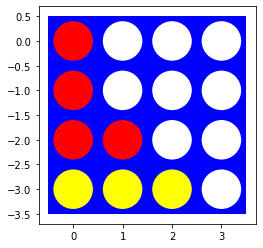

Move Placed:
Number of nodes searched: 5008


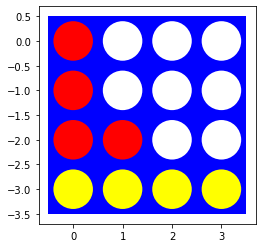

In [192]:
#TEST 1
board = [[1,0,0,0],
         [1,0,0,0],
         [1,1,0,0],
         [-1,-1,-1,0]]

LAST_MOVE = (-1,1)
print(" \t Test 1: \n Original Board:")
visualize(board)
print("Move Placed:")
visualize(result(board, minimax_ab_move(board, -1), -1))

Test 2 plays for red and tests to see if a winning vertical move is chosen.

 	 Test 2: 
 Original Board:


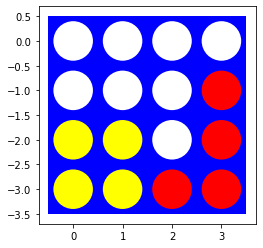

Move Placed:
Number of nodes searched: 32196


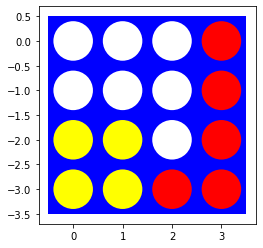

In [193]:
#TEST 2
board = [[0,0,0,0],
         [0,0,0,1],
         [-1,-1,0,1],
         [-1,-1,1,1]]

LAST_MOVE = (-1,1)
print(" \t Test 2: \n Original Board:")
visualize(board)
print("Move Placed:")
visualize(result(board, minimax_ab_move(board, 1), 1))

Test 3 plays for red. This test checks if red can choose the move that will block yellow from winning vertically, and win diagonally(top-right to bottom-left).

 	 Test 3: 
 Original Board:


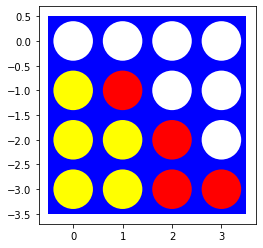

Move Placed:
Number of nodes searched: 40104


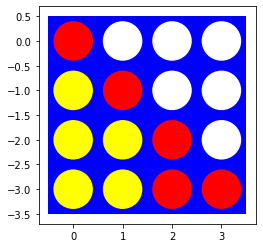

In [148]:
#TEST 3
board = [[0,0,0,0],
         [-1,1,0,0],
         [-1,-1,1,0],
         [-1,-1,1,1]]

LAST_MOVE = (-1,0)
print(" \t Test 3: \n Original Board:")
visualize(board)
print("Move Placed:")
visualize(result(board, minimax_ab_move(board, 1), 1))

Test 4 plays for yellow. This checks to see that yellow will choose a winning diagonal (bottom-left to top-right) move when a blocking diagonal (top-right to bottom-left) move is available.

 	 Test 4: 
 Original Board:


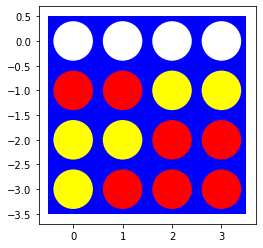

Move Placed:
Number of nodes searched: 2505


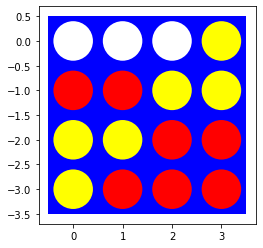

In [156]:
#TEST 4
board = [[0,0,0,0],
         [1,1,-1,-1],
         [-1,-1,1,1],
         [-1,1,1,1]]

LAST_MOVE = (-1,1)
print(" \t Test 4: \n Original Board:")
visualize(board)
print("Move Placed:")
visualize(result(board, minimax_ab_move(board, -1), -1))

Test 5 is playing for red. This tests if red will make a mean move to win the game.

 	 Test 5: 
 Original Board:


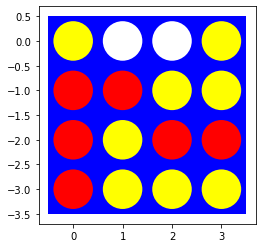

Move Placed:
Number of nodes searched: 136


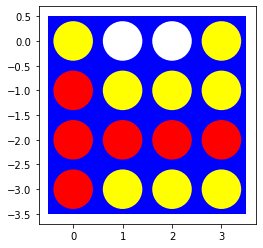

In [268]:
#TEST 5
MEAN_MOVE = 1
board = [[-1,0,0,-1],
         [1,1,-1,-1],
         [1,-1,1,1],
         [1,-1,-1,-1]]

LAST_MOVE = (-1,0)
print(" \t Test 5: \n Original Board:")
visualize(board)
print("Move Placed:")
visualize(result(board, minimax_ab_move(board, 1), 1))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

The mean-move mode is disable for this section because it overflows the python recursion limits as board size increases.

In [256]:
MEAN_MOVE = 0
board = [[0,0,0,0],
         [0,0,0,1],
         [-1,-1,0,1],
         [-1,-1,1,1]]

print("Time for a 4x4")
LAST_MOVE = (-1,0)
%time minimax_ab_move(board, 1)

board = [[0,0,0,0,0],
         [0,0,0,1,0],
         [-1,-1,0,1,0],
         [-1,-1,1,1,0]]

print("\nTime for a 4x5")
LAST_MOVE = (-1,0)
%time minimax_ab_move(board, 1)

board = [[0,0,0,0,0,0],
         [0,0,0,1,0,0],
         [-1,-1,0,1,0,0],
         [-1,-1,1,1,0,0]]

print("\nTime for a 4x6")
LAST_MOVE = (-1,0)
%time minimax_ab_move(board, 1)

Time for a 4x4
Number of nodes searched: 55
CPU times: user 1.97 ms, sys: 110 µs, total: 2.08 ms
Wall time: 2.11 ms

Time for a 4x5
Number of nodes searched: 4051
CPU times: user 131 ms, sys: 2.48 ms, total: 133 ms
Wall time: 134 ms

Time for a 4x6
Number of nodes searched: 16401
CPU times: user 537 ms, sys: 3.34 ms, total: 541 ms
Wall time: 542 ms


(-1, 5)

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [374]:
#actions
#returns a list of all available moves for a given player
def get_actions(board, player):
    norm_actions = []
    mean_actions = []
    shiftable_cols = []

    if MEAN_MOVE == 1:
        #finding all the shiftable columns
        for index, col in enumerate(board[-1]):
            if col == -player: shiftable_cols.append(index)
    
    num_cols = len(board[0])

    #reverse iterating through numer of cols//2
    for idx in reversed(range((num_cols//2)+1)):
        col_1 = idx
        col_2 = num_cols-idx
        add_col_1 = board[0][col_1] == 0
        add_col_2 = idx != 0 and board[0][col_2] == 0

        #adding the index of col_1 if it is not filled to the front of actions list
        if add_col_1: norm_actions.append((-1, col_1))
            
        #adding the index of col_2 to the front of the actions list if it is not the same as col_1 not it is not filled
        if add_col_2: norm_actions.append((-1, col_2))

        if MEAN_MOVE == 1:
            for shift in shiftable_cols:
                #adding a shift move where the tile is placed in col_1 if available
                if add_col_1: mean_actions.append((shift, col_1))
                #adding a shift move where the tile is placed in col_2 if available
                if add_col_2: mean_actions.append((shift, col_2))
                #adding a shift move to add tile back to top of same shifted row
                if board[0][shift] !=0 : mean_actions.append((shift, shift))
    
    return norm_actions+mean_actions
MEAN_MOVE = 1


board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, -1]]

print(get_actions(board, 1))
    

[(-1, 3), (-1, 4), (-1, 2), (-1, 5), (-1, 1), (-1, 6), (-1, 0), (6, 3), (6, 4), (6, 2), (6, 5), (6, 1), (6, 6), (6, 0)]


My move ordering strategy now populated the list of actionis in a middle out method. I determined that moves in the middle of the board are preferable early in the game so the middle columns are now the ones that begin my action list. Previously, I had my mean moves at the end of my action list because they are typically not desireable when a normal move is an option. I did this again in my new move ordering function. Putting mean moves at the end of my actions list increases the speed that a move is chosen because thhe are usually pruned out of the minimax tree.<br><br>
My new method for getting the actions should also be faster than my oly one because it only has to iiterate through half of the number of columns each time it is called, rather than interating though the whole number of columns.<br><br>
The results of my new move ordering are displayed above. Each tuple represents a move, the first element is the row to be shifted and the second element is the row to be placed. A normal move is denoted by -1 as the column to be shifted.<br><br>
Below is a table comparing the time to make a move before and after move-ordering for boards of different sizes. Values for move-ordering time are calculated below, values for no-move-ordering come from the previous section.

In [271]:
MEAN_MOVE = 0
board = [[0,0,0,0],
         [0,0,0,1],
         [-1,-1,0,1],
         [-1,-1,1,1]]

print("Time for a 4x4")
LAST_MOVE = (-1,0)
%time minimax_ab_move(board, 1)

board = [[0,0,0,0,0],
         [0,0,0,1,0],
         [-1,-1,0,1,0],
         [-1,-1,1,1,0]]

print("\nTime for a 4x5")
LAST_MOVE = (-1,0)
%time minimax_ab_move(board, 1)

board = [[0,0,0,0,0,0],
         [0,0,0,1,0,0],
         [-1,-1,0,1,0,0],
         [-1,-1,1,1,0,0]]

print("\nTime for a 4x6")
LAST_MOVE = (-1,0)
%time minimax_ab_move(board, 1)

board = [[0,0,0,0,0,0,0],
         [0,0,0,1,0,0,0],
         [-1,-1,0,1,0,0,0],
         [-1,-1,1,1,0,0,0]]

print("\nTime for a 4x7")
LAST_MOVE = (-1,0)
%time minimax_ab_move(board, 1)

Time for a 4x4
Number of nodes searched: 496
CPU times: user 17.5 ms, sys: 642 µs, total: 18.1 ms
Wall time: 18.5 ms

Time for a 4x5
Number of nodes searched: 476
CPU times: user 17.5 ms, sys: 1.23 ms, total: 18.7 ms
Wall time: 18.4 ms

Time for a 4x6
Number of nodes searched: 1319
CPU times: user 44.6 ms, sys: 781 µs, total: 45.3 ms
Wall time: 45.8 ms

Time for a 4x7
Number of nodes searched: 62019
CPU times: user 2.23 s, sys: 22.1 ms, total: 2.25 s
Wall time: 2.29 s


(-1, 3)

|  Board Size    | No Move-Ordering                  | Move-Ordering |
| -------------- | --------------------------------- | ------------- |
| 4x4            | 2.11 ms                           | 18.5 ms       |
| 4x5            | 134 ms                            | 18.4 ms       |
| 4x6            | 542 ms                            | 45.8 ms       |
| 4x7            | >2 minutes (execution terminated) | 2290 ms       |

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

For this scenario, I can modify my minimax search by immediately choosing a middle column if it encounters an empty board. While I could easily do so by just checking my LAST_MOVE global variable to see if a move had been previously made, I would consider that cheating. I only have the variable because I initially implemented my transition, terminal and utility functions to take in the last_move as a parameter. I did so before I realized that is not the intended implementation. I spend a lot of time on those functions and I was proud of the work so the easiest fix seemed to be to make LAST_MOVE a global variable and remove it as a parameter for my utility function.<br><br>
Anyway, in order to address the empty board problem, I can modify my minimax search as shown below:

In [289]:
import math
# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def minimax_ab_move(board, player):

    #returning a move in the middle of the board if the board is empty
    if np.count_nonzero(board[-1]) == 0:
        return (-1, (len(board[-1]) // 2) )

    value, move = alpha_beta_search(board, player)
    return move

def alpha_beta_search(board, player = 1):

    """start the search."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    return value, move

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: 
        print("max: " + str(state) + str([alpha, beta, v]) )
        print(LAST_MOVE)
    if v is not None: return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in get_actions(state, player):
        
        v2, a2 = min_value_ab(result(state, a, player), player, alpha, beta)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move

    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: 
        print("min: " + str(state) + str([alpha, beta, v]) )
        print(LAST_MOVE)
    if v is not None: return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in get_actions(state, player):
        if a!=(-1,-1):
            v2, a2 = max_value_ab(result(state, a, -player), player, alpha, beta)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha: return v, move

    return v, move
  

In [278]:
MEAN_MOVE = 0
board = [[0,0,0,0],
         [0,0,0,0],
         [0,0,0,0],
         [0,0,0,0]]

print("Time for a 4x4 board without 1st Move Modification")
LAST_MOVE = (-1,-1)
%time minimax_ab_move(board, 1)

Time for a 4x4 board without 1st Move Modification
Number of nodes searched: 516008
CPU times: user 15.1 s, sys: 158 ms, total: 15.3 s
Wall time: 15.6 s


(-1, 2)

In [280]:
MEAN_MOVE = 0
board = [[0,0,0,0],
         [0,0,0,0],
         [0,0,0,0],
         [0,0,0,0]]

print("Time for a 4x4 board with 1st Move Modification")
LAST_MOVE = (-1,-1)
%time minimax_ab_move(board, 1)

Time for a 4x4 board with 1st Move Modification
CPU times: user 24 µs, sys: 1e+03 ns, total: 25 µs
Wall time: 27.9 µs


(-1, 2)

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [293]:
MEAN_MOVE = 0
board = [[0,0,0,0],
         [0,0,0,0],
         [0,0,0,0],
         [0,0,0,0]]

res = play(minimax_ab_move, random_player, board, 10)

red:  7  yellow:  0  draw:  3


In [294]:
MEAN_MOVE = 0
board = [[0,0,0,0],
         [0,0,0,0],
         [0,0,0,0],
         [0,0,0,0]]

res = play(random_player, minimax_ab_move, board, 10)

red:  0  yellow:  7  draw:  3


For these experiments, I played my minimax search against my random player without the mean move. When I tried to include the mean-move, the games would ech take multiple minutes to complete.<br><br>

After playing 20 games, the minimax algorithm won 14 times, lost 0 times and there was a draw 6 times. I ran 10 games where the minimax search wennt first and 10 games where the random player went first to minimize any advantage. While I am suprised about a 30% draw rate, the results do make sense. The minimax algorithm is optimized to not lose games, and it surely did its job.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

My heuristic evaluation function assigns different scores to different types of moves. If multiple types of moves are made, the move with the highest score is the score that is returned. <br><br>
The scores for moves are as follows:
* A winning move has a score of 5
* A move that blocks you opponent from winnning has a score of 4
* A move that give you 3 in a row or blocks an opponent's 3 in a row both have a score of 3
* A move that gives you 2 in a row has a score of 2
* A move that blocks your opponen's 2 in a row has a score of 1
* A move that blocks nothing and created a 1-in-a-row has a score of 0

In [352]:
#setting scores for each adjacent tile count
score = {0:0, -1:1, 1:2, 2:3, -2:3, -3:4, 3:5}

def eval_vert(board, last_move, player):
    row_placed = 0
    #finding location of most recently placed piece
    while board[row_placed][last_move[1]] == 0 and row_placed != len(board)-1: row_placed+=1

    #finding sum of total number of similar pieces below the current piece
    pos_score = 0
    nxt_pos = row_placed+1
    while (nxt_pos) < len(board) and board[nxt_pos][last_move[1]] == player:
        pos_score +=1
        nxt_pos +=1

    #finding sum of total number of opposite pieces below the current piece
    neg_score = 0
    nxt_neg = row_placed+1
    while (nxt_neg) < len(board) and board[nxt_neg][last_move[1]] == -player:
        neg_score -=1 
        nxt_neg +=1

    #normalizing values for score finding
    if pos_score > 3: pos_score = 3
    if neg_score < -3: neg_score = -3

    return max(score[pos_score], score[neg_score])

#setting the score for horizontal combinations
def eval_horiz(board, last_move, player):
    row_placed = 0
    row_shifted = 0
    scores = []

    #not executing if the last move was a shift and the tile was place in the same column
    if last_move[0] != last_move[1]:

        #finding location of most recently placed piece
        while board[row_placed][last_move[1]] == 0 and row_placed != len(board)-1: row_placed+=1
        #finding the left-most possible position of a row of 4 containing the previously placed piece
        left_pos = (last_move[1]-3, 0)[last_move[1]<3]

        #looping though all possible horizontal rows containing the previously placed piece
        #left_pos+3 < len(board[0]) and
        while(left_pos <= last_move[1]):

            #finding sum of total number of similar pieces to the right of the leftmost
            pos_score = 0
            nxt_pos = copy.deepcopy(left_pos)
            while (nxt_pos) < len(board) and board[row_placed][nxt_pos] == player:
                pos_score +=1
                nxt_pos +=1

            #finding sum of total number of opposite pieces to the right of the leftmost
            neg_score = 0
            nxt_neg = copy.deepcopy(left_pos)
            while (nxt_neg) < len(board) and board[row_placed][nxt_neg] == -player:
                neg_score -=1 
                nxt_neg +=1

            #normalizing values for score finding
            if pos_score > 3: pos_score = 3
            if neg_score < -3: neg_score = -3

            scores.append(max(score[pos_score],score[neg_score]))
            left_pos+=1

    #checking if most recent move was a shift move
    if last_move[0] >= 0:
        #finding top of most recently shifted column

        while board[row_shifted][last_move[0]] == 0 and row_shifted != len(board)-1 : row_shifted+=1

        for row in range(row_shifted, len(board)):
            #finding the left-most possible position of a row of 4 containing the previouly placed piece
            left_pos = (last_move[0]-3, 0)[last_move[0]<3]

            #looping though all possible horizontal rows containing the previously placed piece
            #left_pos+3 < len(board[0]) and
            while(left_pos <= last_move[0]):

                #finding sum of total number of similar pieces to the right of the leftmost
                pos_score = 0
                nxt_pos = copy.deepcopy(left_pos)
                while (nxt_pos) < len(board) and board[row][nxt_pos] == player:
                    pos_score +=1
                    nxt_pos +=1

                #finding sum of total number of opposite pieces to the right of the leftmost
                neg_score = 0
                nxt_neg = copy.deepcopy(left_pos)
                while (nxt_neg) < len(board) and board[row][nxt_neg] == -player:
                    neg_score -=1 
                    nxt_neg +=1

                #normalizing values for score finding
                if pos_score > 3: pos_score = 3
                if neg_score < -3: neg_score = -3

                scores.append(max(score[pos_score],score[neg_score]))

                left_pos+=1

    #returning the highest of all accumulated scores
    return max(scores)


#function checks all diagonals for piece at a given location and returns result, 0 if no wins
def piece_diag_eval(board, piece_pos, player):
    scores = []

    #finding the upper left end of a diagonal with recently placed tile given board contraints
     #top_left = [col,row]
    if piece_pos[1] >2 and piece_pos[0]>2:
        top_left = [piece_pos[0]-3, piece_pos[1]-3]
    elif piece_pos[1] > piece_pos[0]:
        top_left = [0, piece_pos[1]-piece_pos[0]]
    else:
        top_left = [piece_pos[0]-piece_pos[1], 0]


    #finding the bottom left end of a diagonal with recently placed tile given board contraints
    #bot_left = [col,row]
    if (len(board) - piece_pos[1]) > 3 and piece_pos[0]>2:
        bot_left = [piece_pos[0]-3, piece_pos[1]+3]
    elif (len(board) - piece_pos[1])-1 > piece_pos[0]:
        bot_left = [0, piece_pos[1]+piece_pos[0]]
    else:
        bot_left = [piece_pos[0]-( (len(board)-1) - piece_pos[1]), len(board)-1]
    
    #loop checks all top-left diagonals containing the most recently placed tile
    while(top_left[0] <= piece_pos[0]):

        #finding sum of total number of similar pieces in the top-left diagonal
        pos_score = 0
        nxt_pos = copy.deepcopy(top_left)
        while nxt_pos[0] < len(board[0]) and nxt_pos[1] < len(board) and board[nxt_pos[1]][nxt_pos[0]] == player:
            pos_score +=1
            nxt_pos[0] +=1
            nxt_pos[1] +=1

        #finding sum of total number of opposite pieces in the top-left diagonal
        neg_score = 0
        nxt_neg = copy.deepcopy(top_left)
        while nxt_neg[0] < len(board[0]) and nxt_neg[1] < len(board) and board[nxt_neg[1]][nxt_neg[0]] == -player:
            neg_score -=1
            nxt_neg[0] +=1
            nxt_neg[1] +=1

        #normalizing values for score finding
        if pos_score > 3: pos_score = 3
        if neg_score < -3: neg_score = -3

        scores.append(max(score[pos_score],score[neg_score]))

        top_left[0]+=1
        top_left[1]+=1

    #loop checks all bottom-left diagonals containing the most recently placed tile
    while(bot_left[0] <= piece_pos[0]):

        #finding sum of total number of similar pieces in the botttom-left diagonal
        pos_score = 0
        nxt_pos = copy.deepcopy(bot_left)
        while nxt_pos[0] < len(board[0]) and nxt_pos[1] >= 0 and board[nxt_pos[1]][nxt_pos[0]] == player:
            pos_score +=1
            nxt_pos[0] +=1
            nxt_pos[1] -=1

        #finding sum of total number of opposite pieces in the bottom-left diagonal
        neg_score = 0
        nxt_neg = copy.deepcopy(bot_left)
        while nxt_neg[0] < len(board[0]) and nxt_neg[1] >= 0 and board[nxt_neg[1]][nxt_neg[0]] == -player:
            neg_score -=1
            nxt_neg[0] +=1
            nxt_neg[1] -=1

        #normalizing values for score finding
        if pos_score > 3: pos_score = 3
        if neg_score < -3: neg_score = -3

        scores.append(max(score[pos_score],score[neg_score]))

        bot_left[0]+=1
        bot_left[1]-=1

    return max(scores)

#returns top score of diagonals
def eval_diag(board, last_move, player):
    row_placed = 0
    row_shifted = 0
    scores = []

    #not executing if the last move was a shift and the tile was place in the same column
    if last_move[0] != last_move[1]:
        #finding location of most recently placed piece
        while board[row_placed][last_move[1]] == 0 and row_placed != len(board)-1: row_placed+=1

        #adding the score for the move to the scores list
        scores.append(piece_diag_eval(board,[last_move[1], row_placed], player))
    
    #checking if most recent move was a shift move
    if last_move[0] >= 0:
        #finding top of most recently shifted column
        while board[row_shifted][last_move[0]] == 0 and row_shifted != len(board)-1 : row_shifted+=1

        #loop checks every diagonal for every tile in a shifted row
        for row in range(row_shifted, len(board)):

            #adding the score for the move to the scores list
            scores.append(piece_diag_eval(board, [last_move[0], row], player))

    #returning 0 if no diagonal rows were found, returning -1 if the opponent achieved a diagonal row and the player didn't
    return max(scores)

#terminal state
def eval_fun(board, player):
    term = False

    u = utility(board, player)
    if u is not None: term = True

    #if the board is empty return none
    if LAST_MOVE[1] == -1: return None, False
    #calls all funnctions and returns greatest move score
    return max(eval_vert(board, LAST_MOVE, player), eval_horiz(board, LAST_MOVE, player), eval_diag(board, LAST_MOVE, player)), term

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [375]:
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def minimax_ab_cutoff_move(board, cutoff = 8, player = 1):
    move, value = alpha_beta_search(board, cutoff, player)
    return move

def alpha_beta_search(board, cutoff, player):
    """start the search. cutoff = None is minimax search with alpha-beta pruning."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab(board, player, -math.inf, +math.inf, 0, cutoff)
    
    if DEBUG >= 1: print(f"Number of nodes searched (cutoff = {cutoff}): {COUNT}") 
    
    return move, value

def max_value_ab(state, player, alpha, beta, depth, cutoff):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in get_actions(state, player):
        v2, a2 = min_value_ab(result(state, a, player), player, alpha, beta, depth + 1, cutoff)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta, depth, cutoff):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in get_actions(state, player):
        v2, a2 = max_value_ab(result(state, a, -player), player, alpha, beta, depth + 1, cutoff)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

Experimenting with different cutoff values in the section below:

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

When I give my agent Test 1, it will only immediately win if the cutoff is 2 or less. When I increase the cutoff, it must find a win somewhere in 3 moves and chooses that one instead.

 	 Test 1: 
 Original Board:


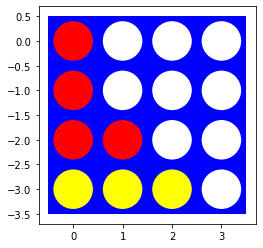

Move Cutoff = 2:
Number of nodes searched (cutoff = 2): 13


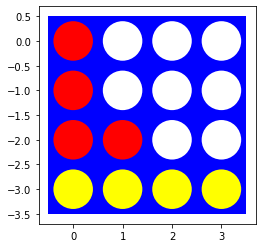

Move Cutoff = 3:
Number of nodes searched (cutoff = 3): 36


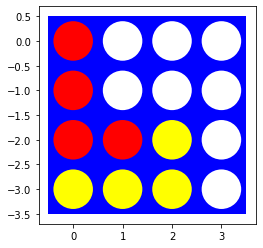

In [372]:
#TEST 1
MEAN_MOVE = 1

board = [[1,0,0,0],
         [1,0,0,0],
         [1,1,0,0],
         [-1,-1,-1,0]]

LAST_MOVE = (-1,1)
print(" \t Test 1: \n Original Board:")
visualize(board)
print("Move Cutoff = 2:")
visualize(result(board, minimax_ab_cutoff_move(board, 2, -1), -1))

print("Move Cutoff = 3:")
visualize(result(board, minimax_ab_cutoff_move(board, 3, -1), -1))

A similar pattern forms with Test 2 as did in test one when I change cutoffs from 2 to 3. This is most likely because htese are very similar tests that are 1 move away from a win. THe only difference is whether the win is vertical or horizontal.

 	 Test 2: 
 Original Board:


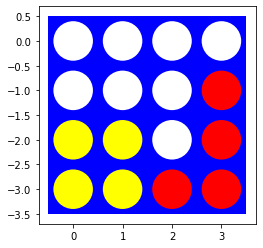

Move Cutoff = 2:
Number of nodes searched (cutoff = 2): 48


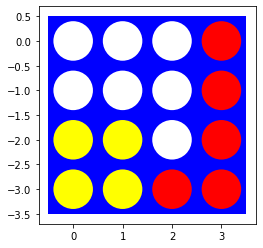

Move Cutoff = 3:
Number of nodes searched (cutoff = 3): 292


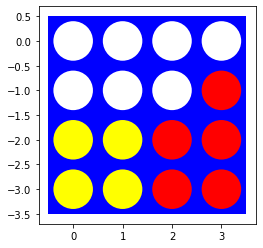

In [373]:
#TEST 2
board = [[0,0,0,0],
         [0,0,0,1],
         [-1,-1,0,1],
         [-1,-1,1,1]]

LAST_MOVE = (-1,1)
print(" \t Test 2: \n Original Board:")
visualize(board)
print("Move Cutoff = 2:")
visualize(result(board, minimax_ab_cutoff_move(board,2, 1), 1))
print("Move Cutoff = 3:")
visualize(result(board, minimax_ab_cutoff_move(board,3, 1), 1))

In test 3 I test cutoff values of 1, 3 and 100, in order to see if I can get a different move with a large cutoff. Interestingly, all of the searches chose the same move, the higher cutoffs just took longer. It is intereasting howsome boards will make different cutoffs behave differently while others make them behave the same.

 	 Test 3: 
 Original Board:


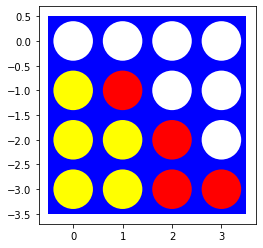

Move Cutoff = 2:
Number of nodes searched (cutoff = 2): 49


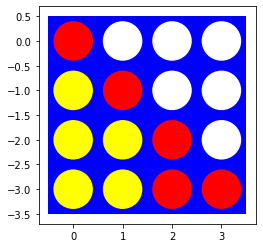

Move Cutoff = 3:
Number of nodes searched (cutoff = 3): 258


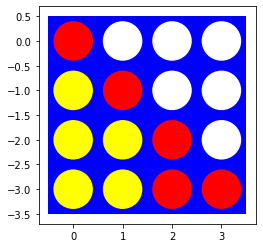

Move Cutoff = 100:
Number of nodes searched (cutoff = 100): 113840


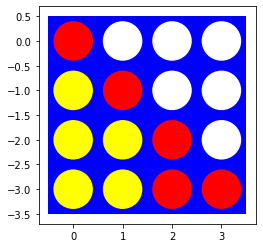

In [376]:
#TEST 3
board = [[0,0,0,0],
         [-1,1,0,0],
         [-1,-1,1,0],
         [-1,-1,1,1]]

LAST_MOVE = (-1,0)
print(" \t Test 3: \n Original Board:")
visualize(board)
print("Move Cutoff = 2:")
visualize(result(board, minimax_ab_cutoff_move(board,2, 1), 1))
print("Move Cutoff = 3:")
visualize(result(board, minimax_ab_cutoff_move(board,3, 1), 1))
print("Move Cutoff = 100:")
visualize(result(board, minimax_ab_cutoff_move(board,100, 1), 1))

In test 4 I tried cutoff values of 2, 10, and 100. Again all three searches chose that same move. Interestingly, the cutoff of 10 and 100 both searched the same number of nodes. A prune most have occured within a tree depth of 10 or less.

 	 Test 4: 
 Original Board:


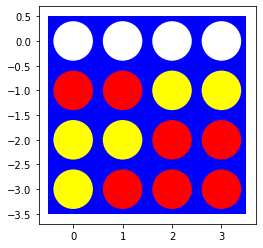

Move Cutoff = 2:
Number of nodes searched (cutoff = 2): 53


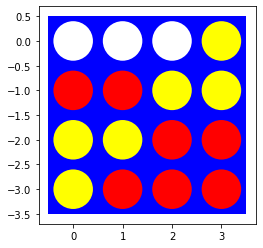

Move Cutoff = 10:
Number of nodes searched (cutoff = 10): 18488


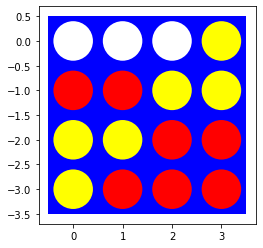

Move Cutoff = 100:
Number of nodes searched (cutoff = 100): 18488


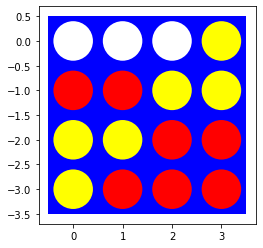

In [377]:
#TEST 4
board = [[0,0,0,0],
         [1,1,-1,-1],
         [-1,-1,1,1],
         [-1,1,1,1]]

LAST_MOVE = (-1,1)
print(" \t Test 4: \n Original Board:")
visualize(board)
print("Move Cutoff = 2:")
visualize(result(board, minimax_ab_cutoff_move(board,2, -1), -1))
print("Move Cutoff = 10:")
visualize(result(board, minimax_ab_cutoff_move(board,10, -1), -1))
print("Move Cutoff = 100:")
visualize(result(board, minimax_ab_cutoff_move(board,100, -1), -1))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [ ]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [ ]:
# Your code/ answer goes here.